
Random Forest Results:
                    precision    recall  f1-score   support

              Ally      0.432     0.500     0.464        32
            Herald      0.536     0.600     0.566        25
              Hero      0.250     0.167     0.200         6
            Mentor      0.000     0.000     0.000         2
            Shadow      0.000     0.000     0.000         5
      Shapeshifter      0.000     0.000     0.000         3
Threshold Guardian      0.000     0.000     0.000         7
         Trickster      0.250     0.222     0.235         9

          accuracy                          0.382        89
         macro avg      0.184     0.186     0.183        89
      weighted avg      0.348     0.382     0.363        89

Macro F1-score: 0.183

Logistic Regression Results:
                    precision    recall  f1-score   support

              Ally      0.714     0.312     0.435        32
            Herald      0.594     0.760     0.667        25
              Hero  

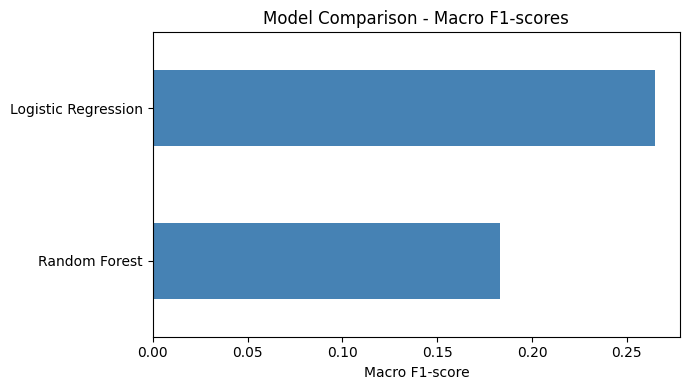

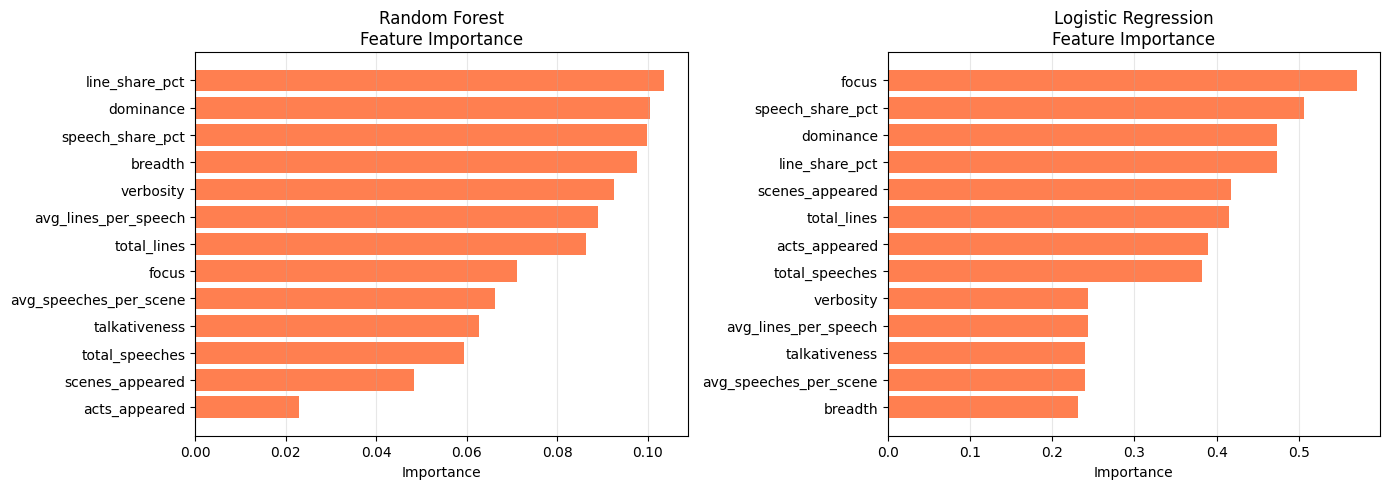


FEATURE IMPORTANCE RANKINGS

Random Forest:
----------------------------------------
1. line_share_pct                 0.1036
2. dominance                      0.1004
3. speech_share_pct               0.0998
4. breadth                        0.0975
5. verbosity                      0.0925
6. avg_lines_per_speech           0.0890
7. total_lines                    0.0864
8. focus                          0.0711
9. avg_speeches_per_scene         0.0663
10. talkativeness                  0.0627
11. total_speeches                 0.0594
12. scenes_appeared                0.0484
13. acts_appeared                  0.0228

Logistic Regression:
----------------------------------------
1. focus                          0.5702
2. speech_share_pct               0.5068
3. line_share_pct                 0.4737
4. dominance                      0.4737
5. scenes_appeared                0.4175
6. total_lines                    0.4146
7. acts_appeared                  0.3897
8. total_speeches          

In [13]:
# ===============================
# Multi-Model Comparison for Archetype Classifier
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- Load and prepare data ---
character_df = pd.read_csv('../csv/all_plays_char_stats.csv')
archetype_df = pd.read_csv('../csv/all_char_archetypes.csv')
df = pd.merge(character_df, archetype_df, on=['character', 'play'], how='inner')

feature_cols = [
    "total_speeches", "total_lines", "scenes_appeared", "acts_appeared",
    "speech_share_pct", "line_share_pct", "avg_speeches_per_scene", "avg_lines_per_speech",
    "verbosity", "talkativeness", "dominance", "focus", "breadth"
]
X = df[feature_cols].fillna(0)
y = df['campbell_archetype']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# --- Define models ---
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, class_weight='balanced', random_state=42
    ),
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, class_weight='balanced')
    )
}

# --- Train, evaluate, and store results ---
results = {}
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results[name] = f1
    
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Macro F1-score: {f1:.3f}")
    
    # Extract feature importances
    if name == "Random Forest":
        importances = model.feature_importances_
        feature_importances[name] = pd.Series(importances, index=feature_cols)
    elif name == "Logistic Regression":
        # For multiclass logistic regression, average absolute coefficients across classes
        coefficients = np.abs(model.named_steps['logisticregression'].coef_).mean(axis=0)
        feature_importances[name] = pd.Series(coefficients, index=feature_cols)

# --- Plot model comparison ---
plt.figure(figsize=(7, 4))
(pd.Series(results)
 .sort_values()
 .plot(kind='barh', color='steelblue'))
plt.title("Model Comparison - Macro F1-scores")
plt.xlabel("Macro F1-score")
plt.tight_layout()
plt.show()

# --- Plot feature importances for each model ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, importances) in enumerate(feature_importances.items()):
    importances_sorted = importances.sort_values(ascending=True)
    
    axes[idx].barh(range(len(importances_sorted)), importances_sorted.values, color='coral')
    axes[idx].set_yticks(range(len(importances_sorted)))
    axes[idx].set_yticklabels(importances_sorted.index)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{name}\nFeature Importance')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# --- Print feature importance rankings ---
print("\n" + "="*60)
print("FEATURE IMPORTANCE RANKINGS")
print("="*60)

for name, importances in feature_importances.items():
    print(f"\n{name}:")
    print("-" * 40)
    importances_sorted = importances.sort_values(ascending=False)
    for rank, (feature, importance) in enumerate(importances_sorted.items(), 1):
        print(f"{rank}. {feature:30s} {importance:.4f}")

# Optional: print summary table
summary = pd.DataFrame(list(results.items()), columns=['Model', 'Macro F1-score']).sort_values('Macro F1-score', ascending=False)
print("\nModel Performance Summary:\n", summary)


Random Forest Results:
Features used: total_lines, speech_share_pct, line_share_pct, avg_speeches_per_scene, avg_lines_per_speech, verbosity, dominance, focus, breadth
Accuracy:          0.472
Macro Precision:   0.231
Macro Recall:      0.241
Macro F1-score:    0.232
Macro ROC AUC:     0.638

Logistic Regression Results:
Features used: scenes_appeared, acts_appeared, speech_share_pct, line_share_pct, dominance
Accuracy:          0.404
Macro Precision:   0.233
Macro Recall:      0.233
Macro F1-score:    0.220
Macro ROC AUC:     0.704


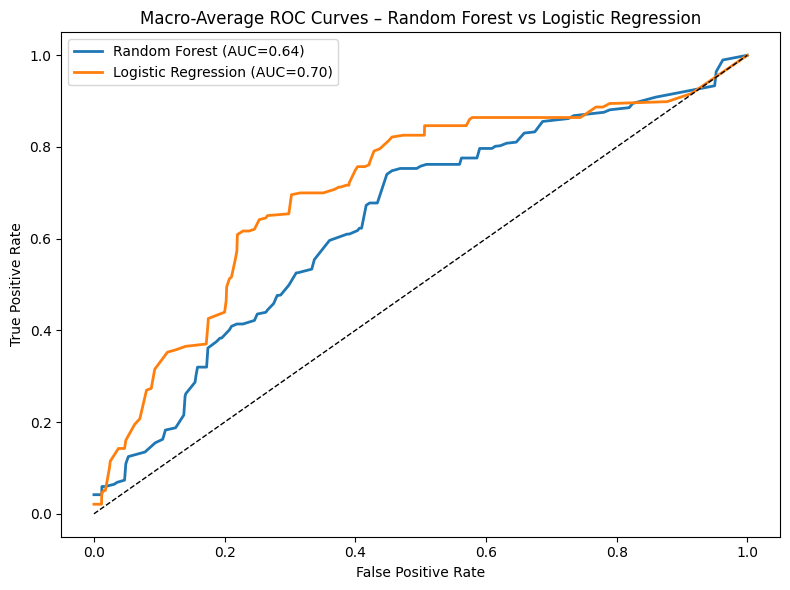

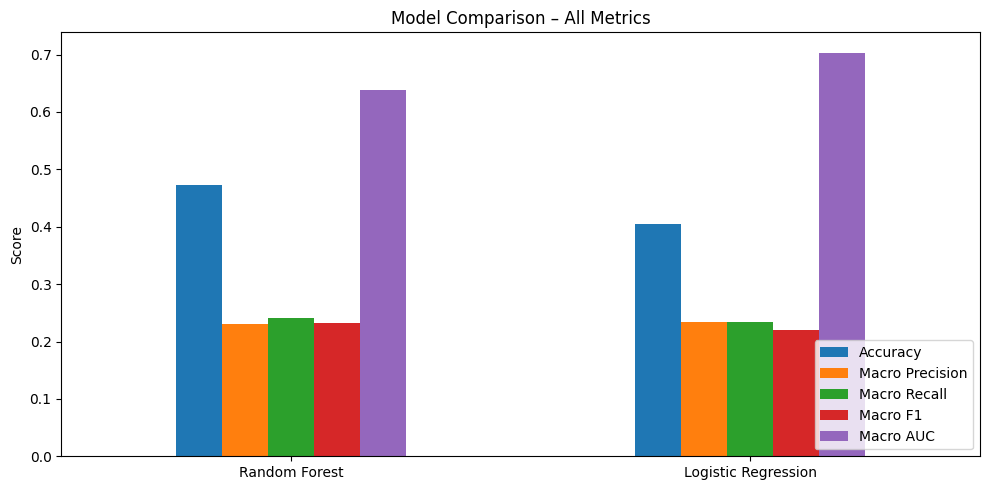


Summary:
                      Accuracy  Macro Precision  Macro Recall  Macro F1  \
Random Forest           0.472            0.231         0.241     0.232   
Logistic Regression     0.404            0.233         0.233     0.220   

                     Macro AUC  
Random Forest            0.638  
Logistic Regression      0.704  


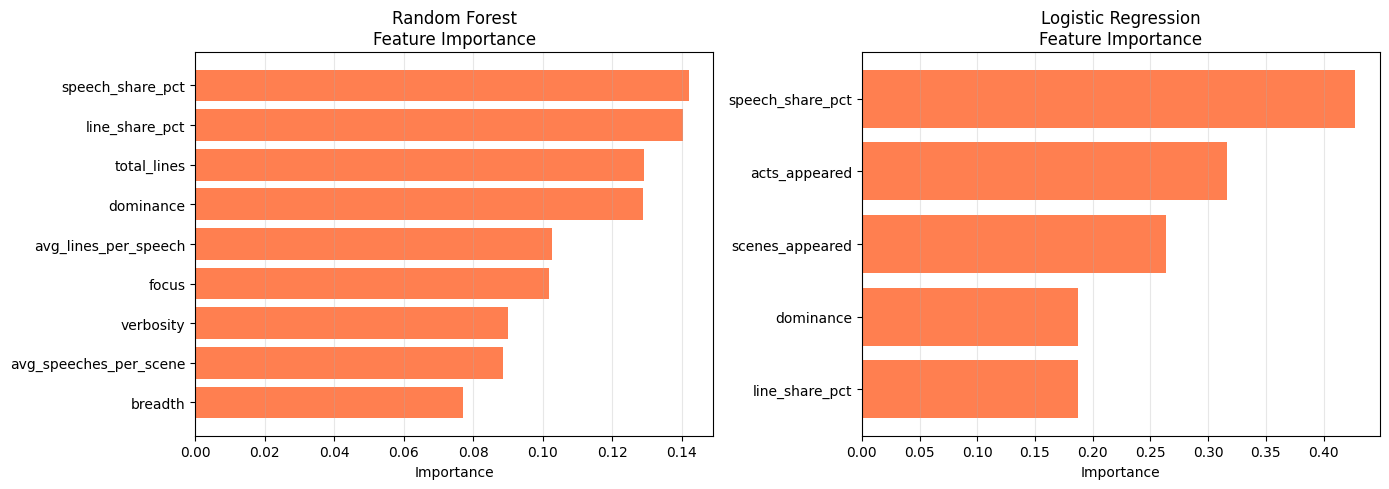


FEATURE IMPORTANCE RANKINGS

Random Forest:
----------------------------------------
1. speech_share_pct               0.1419
2. line_share_pct                 0.1402
3. total_lines                    0.1292
4. dominance                      0.1289
5. avg_lines_per_speech           0.1026
6. focus                          0.1017
7. verbosity                      0.0899
8. avg_speeches_per_scene         0.0885
9. breadth                        0.0770

Logistic Regression:
----------------------------------------
1. speech_share_pct               0.4275
2. acts_appeared                  0.3164
3. scenes_appeared                0.2635
4. line_share_pct                 0.1870
5. dominance                      0.1870


In [20]:
# ===============================
# Multi-Model Comparison with ROC and AUC
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# --- Load and prepare data ---
character_df = pd.read_csv('../csv/all_plays_char_stats.csv')
archetype_df = pd.read_csv('../csv/all_char_archetypes.csv')
df = pd.merge(character_df, archetype_df, on=['character', 'play'], how='inner')

# Define different feature sets for each model
rf_feature_cols = [
    "total_lines", 
    "speech_share_pct", "line_share_pct", "avg_speeches_per_scene", "avg_lines_per_speech",
    "verbosity", "dominance", "focus", "breadth"
]

lg_feature_cols = [
    "scenes_appeared", "acts_appeared",
    "speech_share_pct", "line_share_pct", 
    "dominance"
]

y = df['campbell_archetype']

# Encode labels numerically for ROC
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_bin = label_binarize(y_enc, classes=range(len(le.classes_)))
n_classes = y_bin.shape[1]

# --- Prepare separate datasets for each model ---
X_rf = df[rf_feature_cols].fillna(0)
X_lg = df[lg_feature_cols].fillna(0)

# Split data for Random Forest
X_rf_train, X_rf_test, y_train_bin_rf, y_test_bin_rf = train_test_split(
    X_rf, y_bin, stratify=y_bin, test_size=0.3, random_state=42
)

# Split data for Logistic Regression (same splits)
X_lg_train, X_lg_test, y_train_bin_lg, y_test_bin_lg = train_test_split(
    X_lg, y_bin, stratify=y_bin, test_size=0.3, random_state=42
)

# --- Define models (as OvR for multi-class ROC) ---
models = {
    "Random Forest": {
        'model': OneVsRestClassifier(
            RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, max_depth=5)
        ),
        'X_train': X_rf_train,
        'X_test': X_rf_test,
        'y_train': y_train_bin_rf,
        'y_test': y_test_bin_rf,
        'features': rf_feature_cols
    },
    "Logistic Regression": {
        'model': OneVsRestClassifier(
            LogisticRegression(max_iter=1000, class_weight='balanced')
        ),
        'X_train': X_lg_train,
        'X_test': X_lg_test,
        'y_train': y_train_bin_lg,
        'y_test': y_test_bin_lg,
        'features': lg_feature_cols
    }
}

# --- Train, evaluate, and store results ---
results = {}
roc_curves = {}
feature_importances = {}

for name, config in models.items():
    model = config['model']
    X_train = config['X_train']
    X_test = config['X_test']
    y_train_bin = config['y_train']
    y_test_bin = config['y_test']
    feature_cols = config['features']
    
    # Train model
    model.fit(X_train, y_train_bin)
    y_score = model.predict_proba(X_test)
    y_pred = np.argmax(y_score, axis=1)
    y_true = np.argmax(y_test_bin, axis=1)
    
    # F1 + AUC + Precision + Recall + Accuracy
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    results[name] = {
        'Accuracy': accuracy,
        'Macro Precision': precision,
        'Macro Recall': recall,
        'Macro F1': f1, 
        'Macro AUC': auc_macro
    }
    
    print(f"\n{name} Results:")
    print(f"Features used: {', '.join(feature_cols)}")
    print(f"Accuracy:          {accuracy:.3f}")
    print(f"Macro Precision:   {precision:.3f}")
    print(f"Macro Recall:      {recall:.3f}")
    print(f"Macro F1-score:    {f1:.3f}")
    print(f"Macro ROC AUC:     {auc_macro:.3f}")
    
    # Extract feature importances
    if name == "Random Forest":
        # Average importances across all OvR estimators
        importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
        feature_importances[name] = pd.Series(importances, index=feature_cols)
    elif name == "Logistic Regression":
        # Average absolute coefficients across all OvR estimators
        coefficients = np.mean([np.abs(est.coef_).mean(axis=0) for est in model.estimators_], axis=0)
        feature_importances[name] = pd.Series(coefficients, index=feature_cols)
    
    # Compute macro-average ROC curve
    fpr_dict, tpr_dict = {}, {}
    for i in range(n_classes):
        if y_test_bin[:, i].sum() < 2:  # skip rare classes
            continue
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        fpr_dict[i], tpr_dict[i] = fpr, tpr
    
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in fpr_dict]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in fpr_dict:
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(fpr_dict)
    roc_curves[name] = (all_fpr, mean_tpr)

# --- Plot ROC curves for both models ---
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={results[name]['Macro AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curves – Random Forest vs Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# --- Bar chart comparison (all metrics) ---
summary = pd.DataFrame(results).T
summary.plot(kind='bar', figsize=(10,5))
plt.title("Model Comparison – All Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\nSummary:\n", summary.round(3))

# --- Plot feature importances for each model ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, importances) in enumerate(feature_importances.items()):
    importances_sorted = importances.sort_values(ascending=True)
    
    axes[idx].barh(range(len(importances_sorted)), importances_sorted.values, color='coral')
    axes[idx].set_yticks(range(len(importances_sorted)))
    axes[idx].set_yticklabels(importances_sorted.index)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{name}\nFeature Importance')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# --- Print feature importance rankings ---
print("\n" + "="*60)
print("FEATURE IMPORTANCE RANKINGS")
print("="*60)

for name, importances in feature_importances.items():
    print(f"\n{name}:")
    print("-" * 40)
    importances_sorted = importances.sort_values(ascending=False)
    for rank, (feature, importance) in enumerate(importances_sorted.items(), 1):
        print(f"{rank}. {feature:30s} {importance:.4f}")